## Let's build a Transformers Classifier using Bert

In [1]:
!pip install transformers
!pip install evaluate 
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.7 MB/s 
     |████████████████████████████████| 182 kB 93.7 MB/s 
     |████████████████████████████████| 7.6 MB 83.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.1 MB/s 
     |████████████████████████████████| 452 kB 6.2 MB/s 
     |████████████████████████████████| 212 kB 29.1 MB/s 
     |████████████████████████████████| 132 kB 28.5 MB/s 
     |████████████████████████████████| 127 kB 25.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
import os
import pandas as pd
from datasets import Dataset

In [59]:
weights = "bert-base-german-cased"

In [4]:
!mkdir -p data/processed/raw

In [5]:
# Read training and dev datasets splits
BASE_PATH = os.path.join("./data/processed/raw")

def get_split(split, base_path=BASE_PATH): 
    return pd.read_csv(os.path.join(base_path, f"{split}.csv"))

In [60]:
idx_to_label = {0: "tech", 1: "soft", 2: "none"}
label_to_idx = {"tech": 0, "soft": 1, "none": 2}

In [103]:
train_df = get_split(split="training")[['text', 'label']]
train_df.rename({'label':'label_id'}, inplace=True, axis=1)
train_df['label'] = train_df['label_id'].apply(lambda x: label_to_idx[x])
train_df.head()

,text,label_id,label
0,Wenn Ihnen eine angenehme Arbeitsatmosphäre mi...,none,2
1,***Abitur / Fachhochschulreife,none,2
2,Routinierter Umgang mit MS Office-Anwendungen,tech,0
3,"Standort univativ GmbH Lavesstr. 80, 30159 Han...",none,2
4,"Führerschein der Klasse B, wünschenswert BE, C...",soft,1


In [104]:
dev_df = get_split(split="dev")[['text', 'label']]
dev_df.rename({'label':'label_id'}, inplace=True, axis=1)
dev_df['label'] = dev_df['label_id'].apply(lambda x: label_to_idx[x])
dev_df.head()

,text,label_id,label
0,Assistenz der Geschäftsführung m/w,none,2
1,Detaillierte Kenntnisse des Java Memory Models.,tech,0
2,Umzugsbereitschaft in Richtung Osnabrück (Wohn...,soft,1
3,Ihr Profil:,none,2
4,"Kommunikationsstärke, selbstbewusstes Auftrete...",soft,1


In [105]:
test_df = get_split(split="test")[['text', 'label']]
test_df.rename({'label':'label_id'}, inplace=True, axis=1)
test_df['label'] = test_df['label_id'].apply(lambda x: label_to_idx[x])
test_df.head()

,text,label_id,label
0,Umfangreiche Kenntnisse mind. eines der CAD-Sy...,tech,0
1,Anschreiben:,none,2
2,Sehr gute Kenntnisse der Office-Anwendungen.,tech,0
3,Sie verfügen über ein hohes Maß an Leistungsfä...,soft,1
4,Wenn Sie für Ihre effiziente und umsichtige Ar...,none,2


In [106]:
train_data = Dataset.from_pandas(train_df)
dev_data = Dataset.from_pandas(dev_df)
test_data = Dataset.from_pandas(test_df)

In [107]:
train_data[0]

{'text': 'Wenn Ihnen eine angenehme Arbeitsatmosphäre mit viel Enthusiasmus viel Wert ist, freuen wir uns auf Ihre Bewerbung per E-Mail an recruiting@valyue.de und das persönliche Gespräch mit Ihnen. Frau Asimina Kafida beantwortet Ihre Fragen gerne vorab unter Telefon +49.711.627676-13. Valyue Consulting GmbH www.valyue.de/karriere',
 'label_id': 'none',
 'label': 2}

In [108]:
tokenizer = AutoTokenizer.from_pretrained(weights)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/vocab.txt
loading file tokenizer.json from ca

In [109]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [110]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [111]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [112]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1_score_ = f1_score(labels, predictions, average="weighted")
    acc_ = accuracy_score(labels, predictions)
    precision_score_ = precision_score(labels,predictions, average="weighted")
    recall_score_ = recall_score(labels, predictions, average="weighted")
    return {"accuracy": acc_, "f1": f1_score_, "prec": precision_score_, "recall": recall_score_}

## Load the pre-trained Model

In [113]:
model = AutoModelForSequenceClassification.from_pretrained(weights, 
                                                           num_labels=3, 
                                                           id2label=idx_to_label, 
                                                           label2id=label_to_idx)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-german-cased/snapshots/702774c02b32a4f360d5fea60ab034d64bf0141c/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "tech",
    "1": "soft",
    "2": "none"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "none": 2,
    "soft": 1,
    "tech": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file pytorch_model.bin from cache at /roo

## Tokenized the data

In [114]:
train_tokenized = train_data.map(preprocess_function, batched=True)
dev_tokenized = dev_data.map(preprocess_function, batched=True)
test_tokenized = test_data.map(preprocess_function, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Finetuning the model with our data

In [115]:
training_args = TrainingArguments(
    output_dir="skills_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)
    

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [116]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=dev_tokenized,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [117]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_id, text. If label_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6975
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1744
  Number of trainable parameters = 109083651
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faste

Epoch,Training Loss,Validation Loss,Accuracy,F1,Prec,Recall
1,No log,0.165115,0.951044,0.951104,0.951347,0.951044
2,0.184400,0.177572,0.960836,0.960651,0.960760,0.960836
3,0.065700,0.205141,0.957572,0.957345,0.957616,0.957572
4,0.038400,0.217705,0.959530,0.959350,0.959423,0.959530


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_id, text. If label_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1532
  Batch size = 16
Saving model checkpoint to skills_model/checkpoint-436
Configuration saved in skills_model/checkpoint-436/config.json
Model weights saved in skills_model/checkpoint-436/pytorch_model.bin
tokenizer config file saved in skills_model/checkpoint-436/tokenizer_config.json
Special tokens file saved in skills_model/checkpoint-436/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_id, text. If label_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation

TrainOutput(global_step=1744, training_loss=0.08495615491079628, metrics={'train_runtime': 170.0144, 'train_samples_per_second': 164.104, 'train_steps_per_second': 10.258, 'total_flos': 1146103033567590.0, 'train_loss': 0.08495615491079628, 'epoch': 4.0})

## Save the best model

In [118]:
trainer.save_model("bert-best-model")

Saving model checkpoint to bert-best-model
Configuration saved in bert-best-model/config.json
Model weights saved in bert-best-model/pytorch_model.bin
tokenizer config file saved in bert-best-model/tokenizer_config.json
Special tokens file saved in bert-best-model/special_tokens_map.json


In [119]:
!tar -czvf best_model_bertv1.tar.gz bert-best-model/

bert-best-model/
bert-best-model/config.json
bert-best-model/vocab.txt
bert-best-model/special_tokens_map.json
bert-best-model/training_args.bin
bert-best-model/tokenizer.json
bert-best-model/tokenizer_config.json
bert-best-model/pytorch_model.bin


In [139]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
save_to = "/content/drive/MyDrive/tb_challenge/"
!cp best_model_bertv1.tar.gz $save_to/

Mounted at /content/drive


## Test Load the Best Model

In [120]:
from transformers.pipelines.base import AutoModel
from transformers import BertForSequenceClassification
loaded_model = AutoModel.from_pretrained("./bert-best-model/")

loading configuration file ./bert-best-model/config.json
Model config BertConfig {
  "_name_or_path": "./bert-best-model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "tech",
    "1": "soft",
    "2": "none"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "none": 2,
    "soft": 1,
    "tech": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file ./bert-best-model/pytorch_model.bin
Some weights of the model checkp

**Create a Classifier Pipeline for evaluating on single text data**

In [121]:
from transformers import pipeline

tokenizer_best = AutoTokenizer.from_pretrained("./bert-best-model/")
clf = pipeline("text-classification","./bert-best-model/")


loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file ./bert-best-model/config.json
Model config BertConfig {
  "_name_or_path": "./bert-best-model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "tech",
    "1": "soft",
    "2": "none"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "none": 2,
    "soft": 1,
    "tech": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "ty

In [122]:
text = "Kenntnisse im Bereich Online-Dienste von Vorteil"
test_tokenized = test_data.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

## Evaluation - Metrics and Reporting

In [123]:
metrics = {}
print("*** Predict ***")
results = trainer.predict(test_tokenized)
metrics = results.metrics
metrics["predict_samples"] = len(test_tokenized)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_id, text. If label_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1502
  Batch size = 16


*** Predict ***


In [124]:
print(metrics)

{'test_loss': 0.1613866090774536, 'test_accuracy': 0.9533954727030626, 'test_f1': 0.9535161205780225, 'test_prec': 0.9543163223140806, 'test_recall': 0.9533954727030626, 'test_runtime': 2.2392, 'test_samples_per_second': 670.773, 'test_steps_per_second': 41.979, 'predict_samples': 1502}


In [125]:
y_preds = np.argmax(results.predictions, axis=1)
y_preds

array([0, 2, 0, ..., 0, 1, 2])

In [126]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [127]:
def plot_matrix(y_preds, gold, labels): 
  c_matrix = confusion_matrix(y_true=gold, y_pred=y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(8,8))
  display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix,
                                          display_labels=labels)
  display_matrix.plot(cmap="RdPu",values_format=".2f", ax=ax, colorbar=False)
  plt.title("Confusion Matrix for BERT model")
  plt.show()

In [128]:
classes = ["soft","tech","none"]

In [129]:
gold = np.array(test_data['label'])
gold[:2]

array([0, 2])

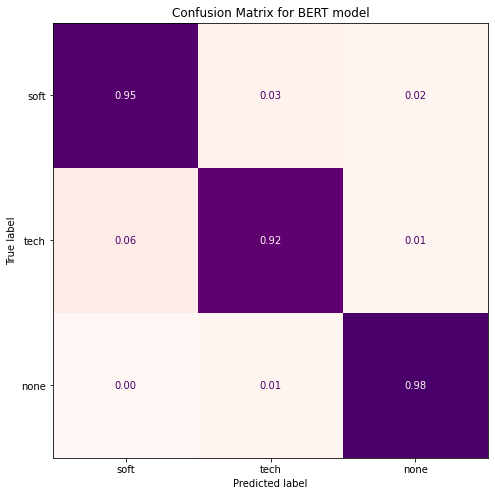

In [130]:
plot_matrix(y_preds, gold, classes)

## Evaluation on Single text

In [94]:
import torch

In [131]:
best_model = "skills_model/checkpoint-436"
text = "Kenntnisse im Bereich Online-Dienste von Vorteil"

In [132]:
tokenizer = AutoTokenizer.from_pretrained(best_model)
inputs = tokenizer(text, return_tensors="pt")

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [135]:
model = BertForSequenceClassification.from_pretrained(best_model)
with torch.no_grad():
    logits = model(**inputs).logits

loading configuration file skills_model/checkpoint-436/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-german-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "tech",
    "1": "soft",
    "2": "none"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "none": 2,
    "soft": 1,
    "tech": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file skills_model/checkpoint-436/pytorch_model.bin
All mode

In [136]:
predicted_class_id = logits.argmax().item()
print(f"Text sample: {text} \nPredicted class:{model.config.id2label[predicted_class_id]}")

Text sample: Kenntnisse im Bereich Online-Dienste von Vorteil 
Predicted class:tech


In [137]:
clf(text)

[{'label': 'tech', 'score': 0.9973288774490356}]